# K-means Clustering 실습
### `Online Retail Dataset`을 이용하여 K-means 클러스터링 시행하는 작업
- dataset : https://archive.ics.uci.edu/ml/datasets/online+retail
- Features

|칼럼 명|칼럼 소개|데이터타입
|---|:--|:--|
|InvoiceNo|주문번호, 'C'로 시작하는 것은 취소 주문 이다.|object|
|StockCode|제품 코드(Item code)|object|
|Description|제품 설명|object|
|Quantity|주문 제품 건수|int64|
|InvoiceDate|주문 일자|datetime64(ns)|
|UnitPrice|제품 단가|float64|
|CustomerID|고객 번호|float65|
|Country|국가명(주문 고객의 국적)|object|

### 1. 데이터 준비하기

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_excel('Online_Retail.xlsx')
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


### 2. 결측치 제거

In [8]:
data = data[data['Quantity'] > 0] # 제품 건수 이상치 제거
data = data[data['UnitPrice'] > 0] # 제품 단가 이상치 제거
data = data[data['CustomerID'].notnull()] # 고객번호 Null 값 제거
data.isnull().sum() # Null 값 확인

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 3. 특성 추출

- 영국 고객만 추출

In [10]:
data['Country'].value_counts()[:5]
data = data[data['Country'] == 'United Kingdom']
print(data.shape) 

(354321, 8)


- 총 금액 특성 생성 : Quantity * UnitPrice
- CustomerID (float >> int)

In [17]:
data['CustomerID'] = data['CustomerID'].astype(int)
data['sale_amount'] = data['Quantity'] * data['UnitPrice']

# 주문 고객 별 데이터 갯수
print(data['CustomerID'].value_counts().head(5))

# 주문 고객별 총 구매 금액 높은순
print(data.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


### 4. RFM 기반 데이터 가공
- `주문코드+상품코드` 기준의 데이터를 Recency, Frequency, Monetart value 데이터로 변경

In [21]:
# 1에 가까운 유일한 식별자 레벨임을 알 수 있음
data.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()


# agg 인자로 함수명들을 딕셔너리 형태로 입력
# - 고객당 최근 주문 일자 / 고객당 주문 갯수 / 고객당 총 주문 금액
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}

cust_df = data.groupby('CustomerID').agg(aggregations)

# 이름 변경
cust_df = cust_df.rename(columns = {    'InvoiceDate': 'Recency',
                                        'InvoiceNo' : 'Frequency',
                                        'sale_amount' : 'Monetary'
                                }
                        )
cust_df = cust_df.reset_index() # 인덱스 추가하여 계층 줄이기
cust_df.head(3)


,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


- 현재 날짜 기준(2011.12.10) 연산 진행

In [22]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df Shapes : ', cust_df.shape)
cust_df.head(3)

cust_df Shapes :  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


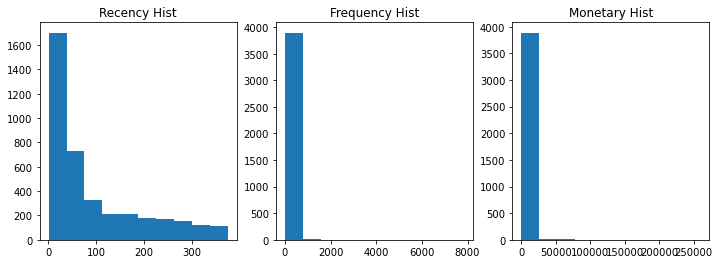

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)

ax1.set_title('Recency Hist')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Hist')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Hist')
ax3.hist(cust_df['Monetary'])

#대략적 분포 확인
cust_df[['Recency','Frequency','Monetary']].describe()

### 5. Kmean 군집화 📌
- 위 대략적 히스토그램 분포를 확인해보면 한쪽으로 쏠리는 왜곡현상이 발생합니다. (주문금액, 주문횟수)
- 군집화를 진행하기 전에 `StandardScaler`로 평균과 표준편차를 재조정 한 후 K-means 값을 구해봅니다.

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples # 실루엣 계수

# 표준화 (StandardScaler)
X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

# Kmeans
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels # 예측한 클러스터 값을 라벨링 합니다.

print('실루엣 스코어 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어 : 0.592


**Eyeball Method**
- 우선 주관적인 판단으로 봤을 때 3개가 적당하다고 나온다.

In [36]:
sum_of_squared_distances = []
K = range(1, 8)
for k in K: # 3번 학습
    km = KMeans(n_clusters = k, random_state=0)
    km = km.fit(X_features_scaled)

    sum_of_squared_distances.append(km.inertia_)
sum_of_squared_distances

[11760.000000000005,
 8504.55925667786,
 5461.264105443648,
 4004.036527893212,
 2939.0949388412055,
 2155.3257444782776,
 1749.4590690174045]

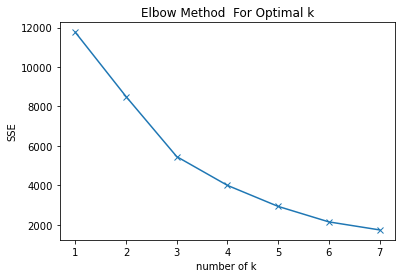

In [37]:
sum_of_squared_distances

plt.plot(K, sum_of_squared_distances, 'x-')
plt.xlabel('number of k ')
plt.ylabel('SSE')
plt.title('Elbow Method  For Optimal k')
plt.show()

### 6. 실루엣 시각화

In [70]:
def visual_silhouette(clusters, x_features):
    # import #
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 시각화 도구 #
    n_cols = len(clusters) # 클러스터링 갯수 만큼 시각화 할 예정
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols) 
    
    for index, n_cluster in enumerate(clusters):
        # Kmeans
        cluster = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = cluster.fit_predict(x_features)
        
        # Silhouette
        sil_avg = silhouette_score(x_features, cluster_labels)
        sil_values = silhouette_samples(x_features, cluster_labels)
        
        # Visualization
        y_lower = 10
        axs[index].set_title('Number of Cluster : ' + str(n_cluster) + '\n' \
                          'Silhouette Score : ' + str(round(sil_avg, 3)))
        axs[index].set_xlabel('The silhouette coefficient values')
        axs[index].set_ylabel('Cluster label')
        
        axs[index].set_xlim([-0.1, 1])
        axs[index].set_ylim([0, len(x_features) + (n_cluster + 1) * 10])

        axs[index].set_xticks([0, .2, .4, .6, .8, 1])
        axs[index].set_yticks([])

        
        # 갯수별 막대 그래프
        for i in range(n_cluster): # 클러스터 갯수별 표현
            ith_cluster_sil_values = sil_values[cluster_labels == i] # 클러스터 개수에 해당하는 실루엣 값
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[index].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                  facecolor = color, edgecolor = color, alpha = 0.7)
            axs[index].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[index].axvline(x=sil_avg, color = 'red', linestyle = '--')

In [71]:
def visual_kmean(clusters, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(clusters)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(clusters):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

[0.02018727 0.67184221 0.6744418  0.73605746 0.22469901 0.7320768
 0.4873169  0.73649788 0.72334046 0.62199206 0.64917603 0.14879993
 0.47208632 0.67604457 0.72997402 0.20902287 0.70781151 0.73403282
 0.67204925 0.55809026 0.64079376 0.73623469 0.50188255 0.26100736
 0.38962782 0.70585452 0.7277525  0.71194095 0.63664034 0.61555378
 0.66416411 0.3480861  0.16866234 0.72488247 0.69142979 0.61201728
 0.69765549 0.48514186 0.69218917 0.62201283 0.64527686 0.73530327
 0.72375197 0.66903485 0.73031478 0.73417936 0.59037604 0.6211593
 0.59451046 0.7357058  0.52461361 0.35472979 0.48451412 0.71345465
 0.62262295 0.13081044 0.71621885 0.72806865 0.73371147 0.73429131
 0.54698922 0.67889693 0.69816155 0.70360422 0.72709657 0.73337414
 0.67130604 0.11038579 0.73522343 0.7004442  0.62651058 0.73558892
 0.63172936 0.69857289 0.64831424 0.73698826 0.62237339 0.33081244
 0.73242989 0.73653136 0.63065734 0.68280783 0.324475   0.56270179
 0.64240908 0.13558696 0.73488434 0.45800402 0.33812684 0.653650

[-0.27168993  0.11896745 -0.08037656 -0.2988809   0.20696287 -0.2030903
 -0.24082123  0.04487059 -0.17834658  0.19603541 -0.32930605  0.23621557
  0.04216398  0.1437924   0.21906732]
[0.67218748 0.6340106  0.71330656 ... 0.68534598 0.25686379 0.70736686]
[0.6634702  0.67301627 0.73426462 0.16996185 0.73101233 0.4614421
 0.73497844 0.72238042 0.61978404 0.63910318 0.08633193 0.44868381
 0.67444203 0.72880636 0.15346683 0.70315838 0.73274771 0.66367617
 0.53925887 0.62961745 0.73454929 0.47773419 0.21052811 0.35343746
 0.70479844 0.72675002 0.71096242 0.63456363 0.60201727 0.65500507
 0.30786505 0.12893194 0.72145234 0.68923631 0.59802263 0.69651778
 0.45887593 0.69101455 0.61980556 0.64344532 0.73398823 0.72271231
 0.66026442 0.72756419 0.73183499 0.5744271  0.61896362 0.57899136
 0.73408932 0.50256436 0.31477848 0.4748457  0.70892536 0.62044507
 0.71211032 0.72630399 0.73176202 0.73293264 0.53000812 0.67750217
 0.69631628 0.70252887 0.72588982 0.73169892 0.66982969 0.73362844
 0.695766

[0.65997461 0.6710462  0.73164217 0.16228756 0.72860958 0.45628265
 0.73240909 0.72009002 0.61802236 0.63549778 0.07799767 0.44397663
 0.67239026 0.72641735 0.1457955  0.70013742 0.73028077 0.6602043
 0.53478463 0.62585032 0.73194528 0.47284905 0.20322363 0.34736178
 0.70264211 0.72441025 0.70875935 0.63280547 0.59800062 0.65145398
 0.30145036 0.1246765  0.7185345  0.68687776 0.59394769 0.69441493
 0.45369125 0.68895023 0.61804455 0.64160155 0.73150949 0.72039828
 0.65671737 0.72476412 0.72909492 0.5701922  0.6172115  0.57479076
 0.73151413 0.49775937 0.30839614 0.47296934 0.70586914 0.61869691
 0.70912765 0.72372755 0.72912195 0.73043186 0.52624308 0.67549928
 0.69404808 0.70038756 0.72348341 0.7291323  0.66784916 0.73107681
 0.69278461 0.61012025 0.7317869  0.61577012 0.68935973 0.63487034
 0.73255725 0.60608524 0.28208866 0.72824971 0.73219777 0.6268095
 0.67948824 0.27468618 0.54025228 0.63870463 0.0629804  0.730771
 0.42357244 0.29072814 0.65006712 0.69185399 0.30880147 0.59488041

[0.66139791 0.67250337 0.7338888  0.15234553 0.73075617 0.45390175
 0.73467018 0.72210538 0.61901857 0.63662475 0.06543951 0.44214081
 0.67393591 0.72851321 0.13533223 0.70213963 0.73245291 0.66161595
 0.53402034 0.62673372 0.73419312 0.47081708 0.1944493  0.34247475
 0.70443429 0.72649202 0.7106398  0.63389077 0.59842667 0.65276406
 0.29532965 0.11801567 0.72073333 0.68866732 0.59434958 0.69611287
 0.45129586 0.690594   0.6190406  0.64279594 0.73370232 0.72243959
 0.65811271 0.72698067 0.73135595 0.57011784 0.61821058 0.57480042
 0.73374116 0.49626073 0.30248802 0.4727819  0.70790256 0.61969866
 0.71117828 0.72592605 0.73133833 0.73262269 0.52548762 0.67699638
 0.69584195 0.70215397 0.72560411 0.73132193 0.66931404 0.73328291
 0.69472284 0.61074694 0.73400921 0.61649736 0.69119586 0.63602995
 0.7348359  0.60680831 0.27566211 0.73039425 0.73445141 0.62785707
 0.68103445 0.26803497 0.53979116 0.63987295 0.73297957 0.42047358
 0.28433177 0.65134414 0.69349538 0.30289658 0.5953936  0.7272

/var/folders/yr/qzwpbhj94x99swfn9xldm4280000gn/T/ipykernel_2893/2213506898.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
/var/folders/yr/qzwpbhj94x99swfn9xldm4280000gn/T/ipykernel_2893/2213506898.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


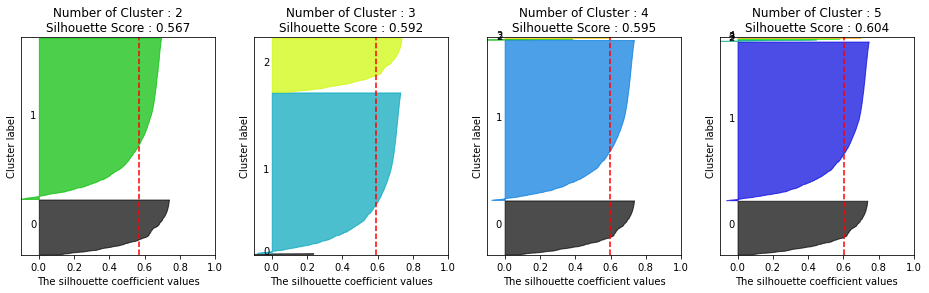

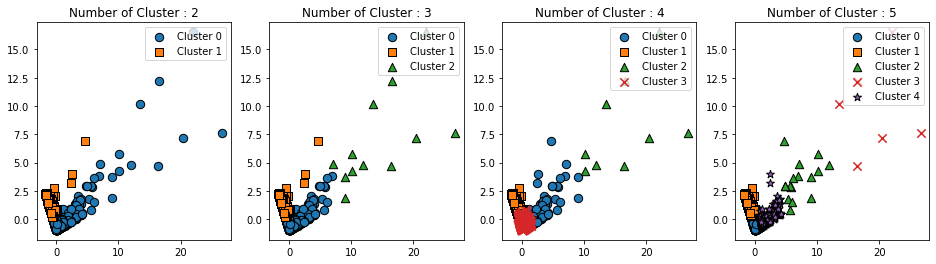

In [72]:
visual_silhouette([2, 3, 4, 5], X_features_scaled)
visual_kmean([2, 3, 4, 5], X_features_scaled)

### 7. 로그 변환 후 실루엣 시각화

In [65]:
# Recency, Frequency, Monetary에 log 변환
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# log 변환 데이터에 scaling 진행
x_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
x_features_scaled = StandardScaler().fit_transform(x_features)


#Kmean
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(x_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(x_features_scaled, labels)))

실루엣 스코어는 : 0.303


/var/folders/yr/qzwpbhj94x99swfn9xldm4280000gn/T/ipykernel_2893/2213506898.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
/var/folders/yr/qzwpbhj94x99swfn9xldm4280000gn/T/ipykernel_2893/2213506898.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


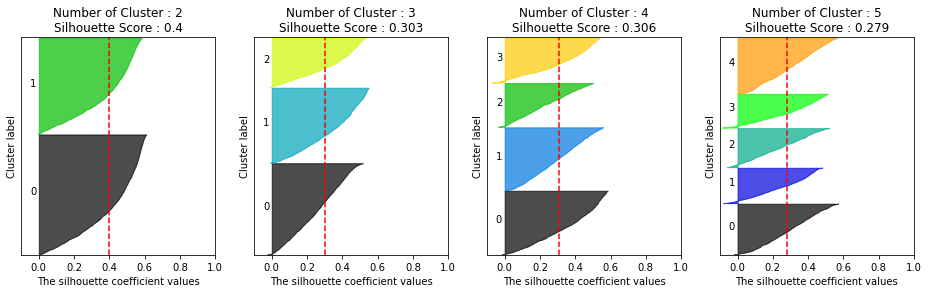

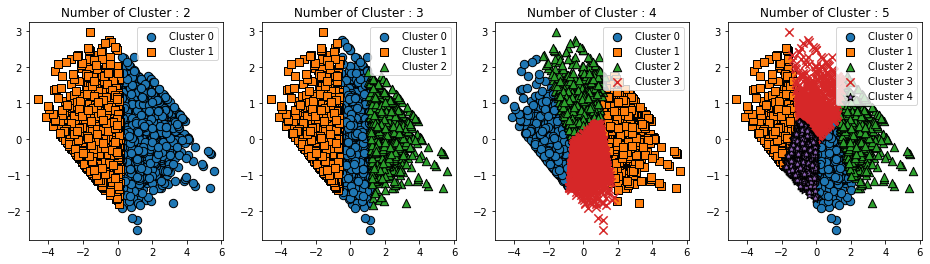

In [66]:
visual_silhouette([2, 3, 4, 5], x_features_scaled)
visual_kmean([2, 3, 4, 5], x_features_scaled)

전체 실루엣 스코어는 전보다 감소했지만 개별 군집은 더욱 균일하게 분류되었다.